  # Unified D⁰ Mass Fits + π⁰ Tag Optimization with Punzi FoM

  **Workflow:**
  1. Fit D⁰ invariant mass for all modes (kmpip, km3pi) and all π⁰ tags (kmpippi0)
  2. Extract fitted σ values to define 3σ mass windows
  3. Load Ds⁺ reconstruction data (DstreeCh2), apply 3σ D⁰ cuts
  4. Compute Punzi FoM across π⁰ efficiency tags for multiple confidence levels

  ## Imports and Setup

In [2]:
# Core
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from IPython.display import display
import os
import time
import gc

# RooFit / ROOT
import ROOT

# plothist
try:
    import plothist as ph
    from plothist import make_hist, plot_hist, plot_data_model_comparison
except Exception as e:
    raise RuntimeError(
        "plothist is required. Install: pip install --user plothist"
    ) from e

# SciPy utilities
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Inline plots and ROOT batch mode
%matplotlib inline
ROOT.gROOT.SetBatch(True)

print(f"ROOT version: {ROOT.gROOT.GetVersion()}")
print(f"plothist version: {ph.__version__}")

ROOT version: 6.36.02
plothist version: 1.6.0


  ## Configuration

In [3]:
# === D⁰ Signal MC Configuration ===
SIGNAL_BASE = "/home/belle2/amubarak/C01-Simulated_Events/Signal"

RUN_MODES = ["kmpip", "km3pi"]  # Fit these once
EFF_TAGS = ["eff10_May2020", "eff20_May2020", "eff30_May2020", 
            "eff40_May2020", "eff50_May2020"]  # kmpippi0 tags

mode_cfg = {
    "kmpip": {
        "tree": "D02kmpiptree",
        "file": "output_test_kmpip.root",
        "var": "D0_kmpip_dM",
        "isig": "D0_kmpip_isSignal",
        "bins": 50,
        "range": (-0.03, 0.03),
        "title": r"$D^{0}\!\to K^{-}\pi^{+}$",
        "sig_model": "gauss",
        "bkg_model": "flat",
    },
    "kmpippi0": {
        "tree": "D02kmpippi0tree",
        "file_fmt": "output_test_kmpippi0_{tag}.root",  # {tag} replaced per scan
        "var": "D0_kmpippi0_dM",
        "isig": "D0_kmpippi0_isSignal",
        "bins": 50,
        "range": (-0.15, 0.10),
        "title": r"$D^{0}\!\to K^{-}\pi^{+}\pi^{0}$",
        "sig_model": "bifurgauss",
        "bkg_model": "cheb2",
    },
    "km3pi": {
        "tree": "D02km3pitree",
        "file": "output_test_km3pi.root",
        "var": "D0_km3pi_dM",
        "isig": "D0_km3pi_isSignal",
        "bins": 50,
        "range": (-0.04, 0.04),
        "title": r"$D^{0}\!\to K^{-}\pi^{+}\pi^{-}\pi^{+}$",
        "sig_model": "gauss",
        "bkg_model": "flat",
    },
}

# Fit seeds per mode
fit_seeds = {
    "kmpip": {
        "mu0": 0.0, "mu_min": -0.01, "mu_max": 0.01,
        "sigma0": 0.005, "sigma_min": 1e-4, "sigma_max": 0.02,
        "Nsig0": 10000, "Nbkg0": 3000,
    },
    "kmpippi0": {
        "mu0": -0.010, "mu_min": -0.04, "mu_max": 0.04,
        "sigmaL0": 0.018, "sigmaL_min": 0.001, "sigmaL_max": 0.08,
        "sigmaR0": 0.023, "sigmaR_min": 0.001, "sigmaR_max": 0.08,
        "c1_0": -0.2, "c2_0": 0.0,
        "Nsig0": 15000, "Nbkg0": 35000,
    },
    "km3pi": {
        "mu0": 0.0, "mu_min": -0.01, "mu_max": 0.01,
        "sigma0": 0.004, "sigma_min": 1e-4, "sigma_max": 0.02,
        "Nsig0": 9000, "Nbkg0": 4000,
    },
}

NGEN_SIGNAL = 100000  # Generated signal events per sample

# === Ds⁺ Reconstruction Configuration (for Punzi FoM) ===
DS_TREE = "DstreeCh2"
VAR_D0_DM = "D0_dM"  # D⁰ mass variable in Ds tree
VAR_LABEL = "Ds_ifNANgiveX_isSignal_5"  # Truth label for Ds⁺

# Generic MC paths (for background)
BKG_BASE = "/group/belle2/users2022/amubarak/Sample_KEKCC"
BKG_EVENT_TYPES = ["ccbar", "ddbar", "uubar", "ssbar", "mixed", "charged"]

# Punzi FoM settings
PUNZI_A_VALUES = [1.64, 1.96, 3.0]  # 90% CL, 95% CL, 3σ discovery
TARGET_LUMI_FB = 200  # Target luminosity for reference (not used in Punzi calculation)

# Plotting style
LINEWIDTH = 2.0
COLORS_STACK = ["purple", "#fd7f6f", "#4C6EB1"]  # NaN, bkg, signal

  ## RooFit Utilities

In [4]:
def numpy_to_roodataset(x, var, name="data"):
    ds = ROOT.RooDataSet(name, name, ROOT.RooArgSet(var))
    aset = ROOT.RooArgSet(var)
    for v in x:
        var.setVal(float(v))
        ds.add(aset)
    return ds

def tmatrix_to_df(m, names):
    n = m.GetNrows()
    arr = np.zeros((n, n), float)
    for i in range(n):
        for j in range(n):
            try:
                arr[i, j] = m[i][j]
            except Exception:
                arr[i, j] = m(i, j)
    return pd.DataFrame(arr, index=names, columns=names)

def save_pdf(var, pdf, n_points=10000):
    xmin, xmax = var.getMin(), var.getMax()
    xs = np.linspace(xmin, xmax, int(n_points))
    ys = np.zeros_like(xs, float)
    for i, xv in enumerate(xs):
        var.setVal(float(xv))
        ys[i] = float(pdf.getVal(var))
    return interp1d(xs, ys, bounds_error=False, fill_value=0.0)

def renormalize_to_yield(pdf_func, x_range, n_bins, yield_events, n_int=5000):
    xmin, xmax = x_range
    bw = (xmax - xmin) / n_bins
    xs = np.linspace(xmin, xmax, int(n_int))
    ys = pdf_func(xs)
    area = trapezoid(ys, xs)
    if area <= 0:
        return lambda x: 0.0 * np.asarray(x)
    scale = (yield_events * bw) / area
    return lambda x: pdf_func(x) * scale

def _build_signal_pdf(dm, model_name, seeds):
    """Build signal PDF: 'gauss', 'bifurgauss', or 'doublegauss'."""
    mu = ROOT.RooRealVar(
        "mu", "mu",
        float(seeds.get("mu0", 0.0)),
        float(seeds.get("mu_min", dm.getMin())),
        float(seeds.get("mu_max", dm.getMax())),
    )

    if model_name == "gauss":
        sigma = ROOT.RooRealVar(
            "sigma", "sigma",
            float(seeds.get("sigma0", 0.005)),
            float(seeds.get("sigma_min", 1e-5)),
            float(seeds.get("sigma_max", 0.1)),
        )
        sig_pdf = ROOT.RooGaussian("sig_gauss", "sig_gauss", dm, mu, sigma)
        return sig_pdf, 2, {"mu": mu, "sigma": sigma}

    elif model_name == "bifurgauss":
        sigmaL = ROOT.RooRealVar(
            "sigmaL", "sigmaL",
            float(seeds.get("sigmaL0", 0.018)),
            float(seeds.get("sigmaL_min", 1e-5)),
            float(seeds.get("sigmaL_max", 0.2)),
        )
        sigmaR = ROOT.RooRealVar(
            "sigmaR", "sigmaR",
            float(seeds.get("sigmaR0", 0.023)),
            float(seeds.get("sigmaR_min", 1e-5)),
            float(seeds.get("sigmaR_max", 0.2)),
        )
        sig_pdf = ROOT.RooBifurGauss("sig_bifur", "sig_bifur", dm, mu, sigmaL, sigmaR)
        return sig_pdf, 3, {"mu": mu, "sigmaL": sigmaL, "sigmaR": sigmaR}
    
    raise ValueError(f"Unknown signal model '{model_name}'")

def _build_background_pdf(dm, model_name, seeds):
    """Build background PDF: 'flat', 'cheb1', 'cheb2', 'expo'."""
    if model_name == "flat":
        bkg = ROOT.RooUniform("bkg_flat", "bkg_flat", ROOT.RooArgSet(dm))
        return bkg, 0, {}

    elif model_name == "cheb1":
        c1 = ROOT.RooRealVar("c1", "c1", float(seeds.get("c1_0", 0.0)), -2.0, 2.0)
        bkg = ROOT.RooChebychev("bkg_cheb1", "bkg_cheb1", dm, ROOT.RooArgList(c1))
        return bkg, 1, {"c1": c1}

    elif model_name == "cheb2":
        c1 = ROOT.RooRealVar("c1", "c1", float(seeds.get("c1_0", 0.0)), -2.0, 2.0)
        c2 = ROOT.RooRealVar("c2", "c2", float(seeds.get("c2_0", 0.0)), -2.0, 2.0)
        bkg = ROOT.RooChebychev("bkg_cheb2", "bkg_cheb2", dm, ROOT.RooArgList(c1, c2))
        return bkg, 2, {"c1": c1, "c2": c2}
    
    raise ValueError(f"Unknown background model '{model_name}'")

def fit_signal_plus_bkg(x, x_range, bins, signal_model, background_model, seeds):
    """Unbinned extended maximum likelihood fit."""
    xmin, xmax = x_range
    dm = ROOT.RooRealVar("dm", "m(D^{0})-m_{PDG}(D^{0}) [GeV/c^{2}]", xmin, xmax)
    dm.setRange("fitRange", xmin, xmax)

    ds = numpy_to_roodataset(x, dm)
    n_tot = len(x)

    sig_pdf, npar_sig, sig_pars = _build_signal_pdf(dm, signal_model, seeds)
    bkg_pdf, npar_bkg, bkg_pars = _build_background_pdf(dm, background_model, seeds)

    Nsig = ROOT.RooRealVar("Nsig", "Nsig", float(seeds.get("Nsig0", 0.6*n_tot)), 0.0, 2.0*n_tot)
    Nbkg = ROOT.RooRealVar("Nbkg", "Nbkg", float(seeds.get("Nbkg0", 0.4*n_tot)), 0.0, 2.0*n_tot)

    model = ROOT.RooAddPdf("model", "sig+bkg",
                           ROOT.RooArgList(sig_pdf, bkg_pdf),
                           ROOT.RooArgList(Nsig, Nbkg))

    fitRes = model.fitTo(ds, ROOT.RooFit.Save(True), ROOT.RooFit.Extended(True), 
                         ROOT.RooFit.PrintLevel(-1))

    out = {
        "Nsig": (Nsig.getVal(), Nsig.getError()),
        "Nbkg": (Nbkg.getVal(), Nbkg.getError()),
        "Ndata": int(n_tot),
        "status": int(fitRes.status()),
        "edm": float(fitRes.edm()),
        "covQual": int(fitRes.covQual()),
        "signal_model": signal_model,
        "npar_signal": npar_sig,
        "npar_bkg": npar_bkg,
    }

    # Extract shape parameters
    if signal_model == "gauss":
        mu_v, sig_v = sig_pars["mu"], sig_pars["sigma"]
        out["mu"] = (mu_v.getVal(), mu_v.getError())
        out["sigma"] = (sig_v.getVal(), sig_v.getError())
        out["sigmaL"] = out["sigmaR"] = out["sigma"]  # For 3σ window calc
    elif signal_model == "bifurgauss":
        mu_v, sL_v, sR_v = sig_pars["mu"], sig_pars["sigmaL"], sig_pars["sigmaR"]
        out["mu"] = (mu_v.getVal(), mu_v.getError())
        out["sigmaL"] = (sL_v.getVal(), sL_v.getError())
        out["sigmaR"] = (sR_v.getVal(), sR_v.getError())

    # Covariance & correlation
    pars = fitRes.floatParsFinal()
    names = [pars[i].GetName() for i in range(pars.getSize())]
    out["covariance_df"] = tmatrix_to_df(fitRes.covarianceMatrix(), names)
    out["correlation_df"] = tmatrix_to_df(fitRes.correlationMatrix(), names)

    # Callables for plotting
    f_sig = save_pdf(dm, sig_pdf)
    f_bkg = save_pdf(dm, bkg_pdf)
    out["sig_callable"] = renormalize_to_yield(f_sig, x_range, bins, out["Nsig"][0])
    out["bkg_callable"] = renormalize_to_yield(f_bkg, x_range, bins, out["Nbkg"][0])
    out["pdf_callable"] = lambda xs: out["sig_callable"](xs) + out["bkg_callable"](xs)

    return out

def entries_per_bin_mev(x_range, bins):
    return (x_range[1] - x_range[0]) / bins * 1000.0

def chisq_ndf_from_hist_and_func(h_data, f_model, npar):
    centers = h_data.axes[0].centers
    data = h_data.values()
    var = h_data.variances()
    if var is None:
        var = np.maximum(data, 1.0)
    var = np.asarray(var, dtype=float)
    model = np.asarray(f_model(centers), dtype=float)
    mask = var > 0
    chi2 = np.sum((data[mask] - model[mask])**2 / var[mask])
    ndf = int(mask.sum() - npar)
    return chi2, ndf, chi2 / max(ndf, 1)

  ## Phase 1: Fit D⁰ Mass Peaks and Extract σ

  ### Fit kmpip and km3pi (once each)


[kmpip] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpip.root:D02kmpiptree
Loaded 32,467 rows
Mode: kmpip | Ndata: 32467 | status: 0 | EDM: 3.54e-05
Nsig: 25597 ± 181
Reco eff: 0.25597 ± 0.00181 (25.60 ± 0.18%)
μ: -0.07 ± 0.03 MeV/c²
σ: 4.74 ± 0.03 MeV/c²
3σ window: [-0.01429, 0.01415] GeV/c²


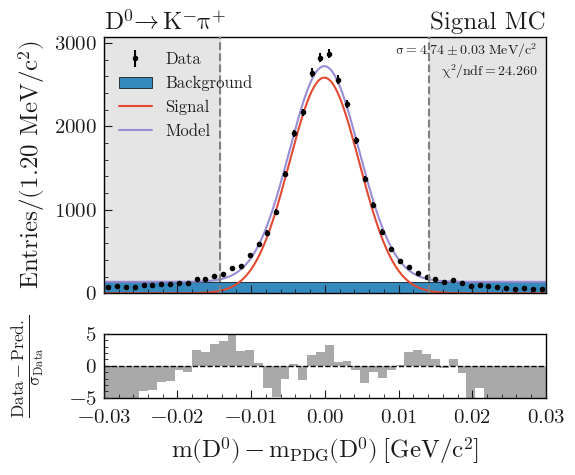


Covariance Matrix:


,Nbkg,Nsig,mu,sigma
Nbkg,14008.098424,-7139.699433,0.000092,-0.001573
Nsig,-7139.699433,32736.689525,-0.000092,0.001573
mu,0.000092,-0.000092,0.000000,-0.000000
sigma,-0.001573,0.001573,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,mu,sigma
Nbkg,1.000,-0.333,0.023,-0.414
Nsig,-0.333,1.000,-0.015,0.271
mu,0.023,-0.015,1.000,-0.033
sigma,-0.414,0.271,-0.033,1.000



[km3pi] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_km3pi.root:D02km3pitree
Loaded 28,743 rows
Mode: km3pi | Ndata: 28743 | status: 0 | EDM: 5.62e-05
Nsig: 18851 ± 159
Reco eff: 0.18851 ± 0.00159 (18.85 ± 0.16%)
μ: -0.29 ± 0.04 MeV/c²
σ: 4.27 ± 0.04 MeV/c²
3σ window: [-0.01309, 0.01252] GeV/c²


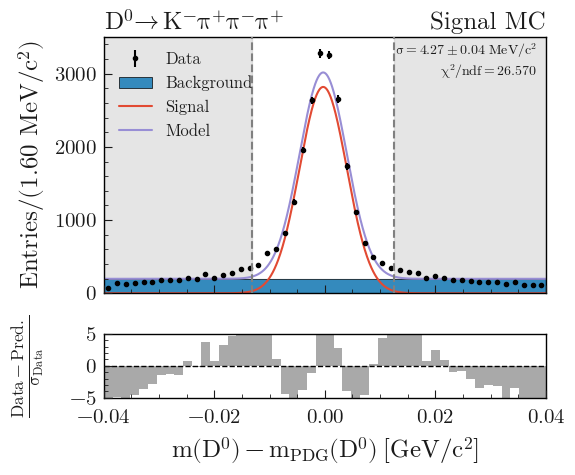


Covariance Matrix:


,Nbkg,Nsig,mu,sigma
Nbkg,16183.154190,-6290.328915,0.000151,-0.002038
Nsig,-6290.328915,25140.831803,-0.000151,0.002038
mu,0.000151,-0.000151,0.000000,-0.000000
sigma,-0.002038,0.002038,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,mu,sigma
Nbkg,1.000,-0.312,0.032,-0.404
Nsig,-0.312,1.000,-0.025,0.324
mu,0.032,-0.025,1.000,-0.052
sigma,-0.404,0.324,-0.052,1.000


[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'fitRange' created with bounds [-0.03,0.03]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using generic CPU library compiled with no vectorizations
[#1] INFO:Fitting -- Creation of NLL object took 2.76166 ms
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization
[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'fitRange' created with bounds [-0.04,0.04]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- Creation of NLL object took 259.829 μs
[#1] INFO:Fitting -- RooAddition::def

In [5]:
fit_results = {}

for mode in RUN_MODES:
    cfg = mode_cfg[mode]
    path = f"{SIGNAL_BASE}/{cfg['file']}:{cfg['tree']}"
    
    print(f"\n{'='*80}\n[{mode}] Loading {path}")
    df = uproot.concatenate(path, library="pd")
    print(f"Loaded {len(df):,} rows")
    
    x_all = df[cfg['var']].dropna().to_numpy(dtype=float)
    
    # Fit
    res = fit_signal_plus_bkg(
        x_all, 
        x_range=cfg['range'], 
        bins=cfg['bins'],
        signal_model=cfg['sig_model'],
        background_model=cfg['bkg_model'],
        seeds=fit_seeds[mode]
    )
    
    fit_results[mode] = res
    
    # Print summary
    Nsig_val, Nsig_err = res["Nsig"]
    eff = Nsig_val / NGEN_SIGNAL
    eff_err = Nsig_err / NGEN_SIGNAL
    
    print(f"Mode: {mode} | Ndata: {res['Ndata']} | status: {res['status']} | EDM: {res['edm']:.2e}")
    print(f"Nsig: {Nsig_val:.0f} ± {Nsig_err:.0f}")
    print(f"Reco eff: {eff:.5f} ± {eff_err:.5f} ({eff*100:.2f} ± {eff_err*100:.2f}%)")
    print(f"μ: {res['mu'][0]*1e3:.2f} ± {res['mu'][1]*1e3:.2f} MeV/c²")
    print(f"σ: {res['sigma'][0]*1e3:.2f} ± {res['sigma'][1]*1e3:.2f} MeV/c²")
    
    # Calculate 3σ window (symmetric for Gaussian)
    mu = res['mu'][0]
    sigma = res['sigma'][0]
    lower_3sig = mu - 3*sigma
    upper_3sig = mu + 3*sigma
    print(f"3σ window: [{lower_3sig:.5f}, {upper_3sig:.5f}] GeV/c²")
    
    # Plot
    x_range = cfg['range']
    xmin, xmax = x_range
    x_plot = x_all[(x_all >= xmin) & (x_all <= xmax)]
    h_data = make_hist(x_plot, bins=cfg['bins'], range=x_range, weights=1)
    
    npar = 2 + res["npar_signal"] + res["npar_bkg"]
    chi2, ndf, chi2_ndf = chisq_ndf_from_hist_and_func(h_data, res["pdf_callable"], npar)
    
    per_bin_mev = entries_per_bin_mev(x_range, cfg['bins'])
    xlabel = r"$m(D^{0}) - m_{\mathrm{PDG}}(D^{0})\;[\mathrm{GeV}/c^{2}]$"
    ylabel = rf"Entries/({per_bin_mev:.2f} MeV/$c^2$)"
    
    fig, ax_main, ax_comp = plot_data_model_comparison(
        data_hist=h_data,
        stacked_components=[res["bkg_callable"]],
        stacked_labels=["Background"],
        unstacked_components=[res["sig_callable"]],
        unstacked_labels=["Signal"],
        xlabel=xlabel,
        ylabel=ylabel,
        model_sum_kwargs={"show": True, "label": "Model"},
        comparison="pull",
    )
    
    # === ADD 3σ BOUNDARY VISUALIZATION ===
    # Shade excluded regions (gray)
    ax_main.axvspan(xmin, lower_3sig, color='gray', alpha=0.2, zorder=0)
    ax_main.axvspan(upper_3sig, xmax, color='gray', alpha=0.2, zorder=0)
    # Vertical lines at 3σ boundaries
    ax_main.axvline(lower_3sig, ls='--', color='gray', lw=1.5, zorder=3)
    ax_main.axvline(upper_3sig, ls='--', color='gray', lw=1.5, zorder=3)
    
    # Fix legend order: move Data to top
    handles, labels = ax_main.get_legend_handles_labels()
    if "Data" in labels:
        idx_data = labels.index("Data")
        handles = [handles[idx_data]] + [h for i, h in enumerate(handles) if i != idx_data]
        labels = [labels[idx_data]] + [l for i, l in enumerate(labels) if i != idx_data]
    
    # Annotation (fit parameters at top-right)
    s, se = res["sigma"]
    txt = (
        rf"$\sigma = {s*1e3:.2f} \pm {se*1e3:.2f}\ \mathrm{{MeV}}/c^2$" + "\n" +
        rf"$\chi^2/\mathrm{{ndf}} = {chi2_ndf:.3f}$"
    )
    ax_main.text(0.98, 0.98, txt, transform=ax_main.transAxes, va="top", ha="right", fontsize=10)
    
    ax_main.set_title(cfg['title'], loc="left")
    ax_main.set_title("Signal MC", loc="right")
    ax_main.legend(handles, labels, loc="upper left", frameon=False)
    
    plt.tight_layout()
    plt.show()
    
    # Matrices
    print("\nCovariance Matrix:")
    display(res["covariance_df"].round(6))
    print("\nCorrelation Matrix:")
    display(res["correlation_df"].round(3))

  ### Fit all kmpippi0 π⁰ efficiency tags


[kmpippi0-eff10_May2020] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff10_May2020.root:D02kmpippi0tree
Loaded 13,277 rows
Tag: eff10_May2020 | Ndata: 13277 | status: 0 | EDM: 1.30e-05
Nsig: 7625 ± 110
Reco eff: 0.07625 ± 0.00110 (7.63 ± 0.11%)
μ: -0.84 ± 0.39 MeV/c²
σ_L: 15.17 ± 0.37 MeV/c²
σ_R: 8.21 ± 0.29 MeV/c²
3σ window: [-0.04636, 0.02379] GeV/c²


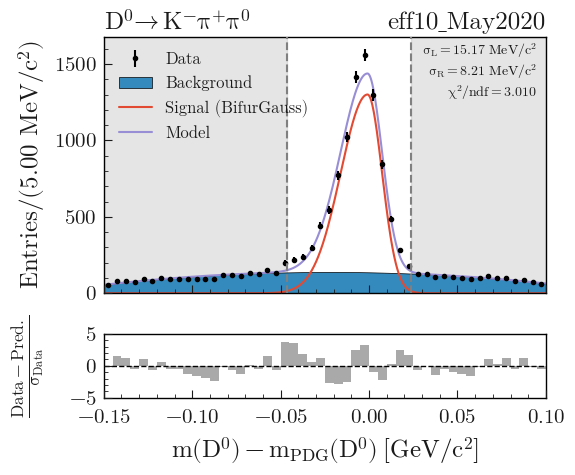


Covariance Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,10120.693148,-4468.568600,0.124371,-1.048289,-0.001851,-0.011431,-0.003402
Nsig,-4468.568600,12093.744093,-0.124366,1.048273,0.001851,0.011431,0.003402
c1,0.124371,-0.124366,0.000534,-0.000003,0.000000,0.000000,-0.000001
c2,-1.048289,1.048273,-0.000003,0.000869,0.000001,0.000003,0.000001
mu,-0.001851,0.001851,0.000000,0.000001,0.000000,0.000000,-0.000000
sigmaL,-0.011431,0.011431,0.000000,0.000003,0.000000,0.000000,-0.000000
sigmaR,-0.003402,0.003402,-0.000001,0.000001,-0.000000,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,1.000,-0.404,0.054,-0.353,-0.047,-0.305,-0.118
Nsig,-0.404,1.000,-0.049,0.323,0.043,0.279,0.108
c1,0.054,-0.049,1.000,-0.004,0.043,0.036,-0.081
c2,-0.353,0.323,-0.004,1.000,0.053,0.264,0.066
mu,-0.047,0.043,0.043,0.053,1.000,0.722,-0.838
sigmaL,-0.305,0.279,0.036,0.264,0.722,1.000,-0.482
sigmaR,-0.118,0.108,-0.081,0.066,-0.838,-0.482,1.000



[kmpippi0-eff20_May2020] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff20_May2020.root:D02kmpippi0tree
Loaded 26,621 rows
Tag: eff20_May2020 | Ndata: 26621 | status: 0 | EDM: 4.18e-04
Nsig: 12988 ± 160
Reco eff: 0.12988 ± 0.00160 (12.99 ± 0.16%)
μ: -0.58 ± 0.34 MeV/c²
σ_L: 17.19 ± 0.34 MeV/c²
σ_R: 8.27 ± 0.25 MeV/c²
3σ window: [-0.05215, 0.02424] GeV/c²


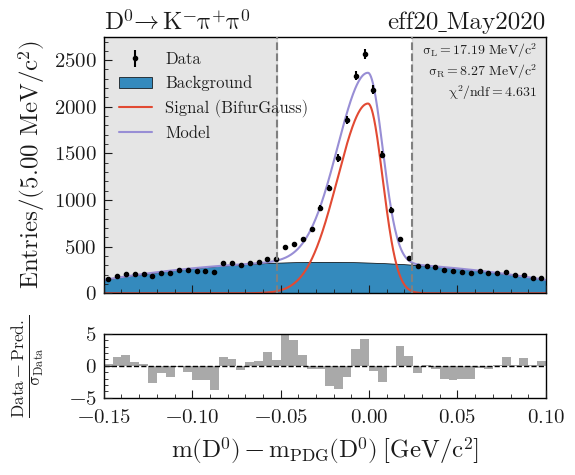


Covariance Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,26085.913522,-12453.060587,0.155075,-1.209915,-0.002680,-0.019410,-0.005288
Nsig,-12453.060587,25443.910433,-0.155061,1.209968,0.002681,0.019415,0.005289
c1,0.155075,-0.155061,0.000222,-0.000015,0.000000,0.000000,-0.000000
c2,-1.209915,1.209968,-0.000015,0.000373,0.000000,0.000002,0.000000
mu,-0.002680,0.002681,0.000000,0.000000,0.000000,0.000000,-0.000000
sigmaL,-0.019410,0.019415,0.000000,0.000002,0.000000,0.000000,-0.000000
sigmaR,-0.005288,0.005289,-0.000000,0.000000,-0.000000,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,1.000,-0.483,0.064,-0.388,-0.049,-0.348,-0.130
Nsig,-0.483,1.000,-0.065,0.393,0.050,0.353,0.131
c1,0.064,-0.065,1.000,-0.052,0.045,0.034,-0.089
c2,-0.388,0.393,-0.052,1.000,0.050,0.295,0.083
mu,-0.049,0.050,0.045,0.050,1.000,0.694,-0.837
sigmaL,-0.348,0.353,0.034,0.295,0.694,1.000,-0.446
sigmaR,-0.130,0.131,-0.089,0.083,-0.837,-0.446,1.000



[kmpippi0-eff30_May2020] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff30_May2020.root:D02kmpippi0tree
Loaded 41,165 rows
Tag: eff30_May2020 | Ndata: 41165 | status: 0 | EDM: 4.04e-05
Nsig: 15506 ± 197
Reco eff: 0.15506 ± 0.00197 (15.51 ± 0.20%)
μ: -0.66 ± 0.34 MeV/c²
σ_L: 17.54 ± 0.36 MeV/c²
σ_R: 8.35 ± 0.26 MeV/c²
3σ window: [-0.05329, 0.02439] GeV/c²


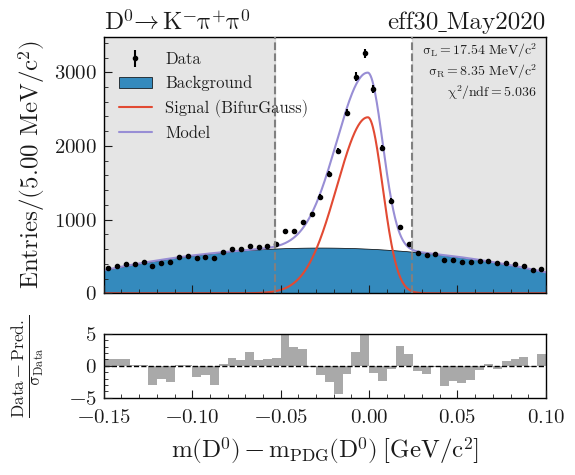


Covariance Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,48936.700133,-23278.647642,0.187944,-1.257622,-0.003195,-0.028454,-0.008414
Nsig,-23278.647642,38787.515079,-0.187926,1.257595,0.003196,0.028457,0.008415
c1,0.187944,-0.187926,0.000120,-0.000013,0.000000,0.000000,-0.000000
c2,-1.257622,1.257595,-0.000013,0.000202,0.000000,0.000002,0.000000
mu,-0.003195,0.003196,0.000000,0.000000,0.000000,0.000000,-0.000000
sigmaL,-0.028454,0.028457,0.000000,0.000002,0.000000,0.000000,-0.000000
sigmaR,-0.008414,0.008415,-0.000000,0.000000,-0.000000,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,1.000,-0.534,0.078,-0.400,-0.043,-0.359,-0.146
Nsig,-0.534,1.000,-0.087,0.449,0.048,0.403,0.164
c1,0.078,-0.087,1.000,-0.083,0.046,0.026,-0.098
c2,-0.400,0.449,-0.083,1.000,0.045,0.311,0.101
mu,-0.043,0.048,0.046,0.045,1.000,0.682,-0.833
sigmaL,-0.359,0.403,0.026,0.311,0.682,1.000,-0.423
sigmaR,-0.146,0.164,-0.098,0.101,-0.833,-0.423,1.000



[kmpippi0-eff40_May2020] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff40_May2020.root:D02kmpippi0tree
Loaded 60,859 rows
Tag: eff40_May2020 | Ndata: 60859 | status: 0 | EDM: 2.42e-04
Nsig: 16773 ± 236
Reco eff: 0.16773 ± 0.00236 (16.77 ± 0.24%)
μ: -0.60 ± 0.35 MeV/c²
σ_L: 17.61 ± 0.40 MeV/c²
σ_R: 8.40 ± 0.28 MeV/c²
3σ window: [-0.05342, 0.02460] GeV/c²


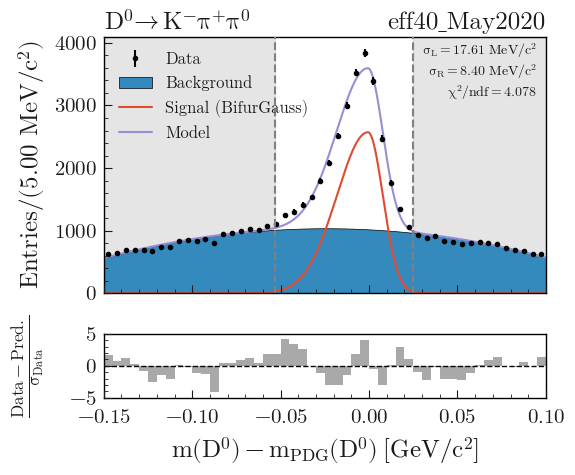


Covariance Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,82785.489246,-38703.823569,0.158310,-1.269314,-0.005431,-0.042207,-0.011493
Nsig,-38703.823569,55487.231655,-0.158311,1.269462,0.005433,0.042218,0.011495
c1,0.158310,-0.158311,0.000070,-0.000005,0.000000,0.000000,-0.000000
c2,-1.269314,1.269462,-0.000005,0.000119,0.000000,0.000001,0.000000
mu,-0.005431,0.005433,0.000000,0.000000,0.000000,0.000000,-0.000000
sigmaL,-0.042207,0.042218,0.000000,0.000001,0.000000,0.000000,-0.000000
sigmaR,-0.011493,0.011495,-0.000000,0.000000,-0.000000,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,1.000,-0.571,0.066,-0.405,-0.053,-0.371,-0.143
Nsig,-0.571,1.000,-0.080,0.494,0.065,0.453,0.175
c1,0.066,-0.080,1.000,-0.051,0.045,0.035,-0.096
c2,-0.405,0.494,-0.051,1.000,0.057,0.335,0.098
mu,-0.053,0.065,0.045,0.057,1.000,0.679,-0.825
sigmaL,-0.371,0.453,0.035,0.335,0.679,1.000,-0.411
sigmaR,-0.143,0.175,-0.096,0.098,-0.825,-0.411,1.000



[kmpippi0-eff50_May2020] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff50_May2020.root:D02kmpippi0tree
Loaded 103,704 rows
Tag: eff50_May2020 | Ndata: 103704 | status: 0 | EDM: 5.83e-04
Nsig: 18905 ± 342
Reco eff: 0.18905 ± 0.00342 (18.91 ± 0.34%)
μ: 0.11 ± 0.41 MeV/c²
σ_L: 20.83 ± 0.55 MeV/c²
σ_R: 7.88 ± 0.33 MeV/c²
3σ window: [-0.06239, 0.02375] GeV/c²


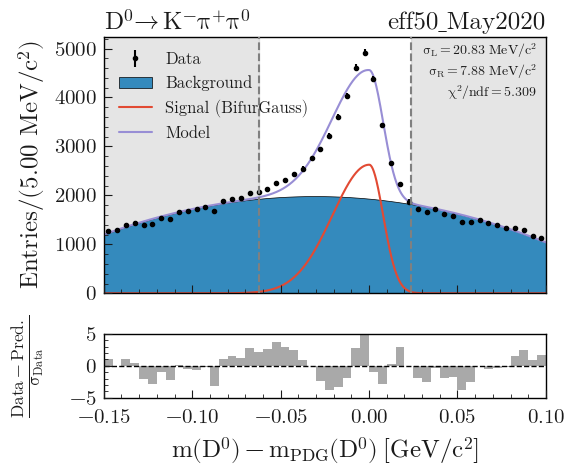


Covariance Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,183036.336590,-98280.532985,0.155661,-1.705763,-0.014309,-0.110639,-0.019932
Nsig,-98280.532985,117223.314198,-0.155702,1.706391,0.014316,0.110688,0.019941
c1,0.155661,-0.155702,0.000037,-0.000004,0.000000,0.000000,-0.000000
c2,-1.705763,1.706391,-0.000004,0.000070,0.000000,0.000002,0.000000
mu,-0.014309,0.014316,0.000000,0.000000,0.000000,0.000000,-0.000000
sigmaL,-0.110639,0.110688,0.000000,0.000002,0.000000,0.000000,-0.000000
sigmaR,-0.019932,0.019941,-0.000000,0.000000,-0.000000,-0.000000,0.000000



Correlation Matrix:


,Nbkg,Nsig,c1,c2,mu,sigmaL,sigmaR
Nbkg,1.000,-0.671,0.060,-0.478,-0.081,-0.469,-0.142
Nsig,-0.671,1.000,-0.075,0.597,0.102,0.587,0.178
c1,0.060,-0.075,1.000,-0.077,0.047,0.045,-0.100
c2,-0.478,0.597,-0.077,1.000,0.073,0.417,0.112
mu,-0.081,0.102,0.047,0.073,1.000,0.628,-0.823
sigmaL,-0.469,0.587,0.045,0.417,0.628,1.000,-0.344
sigmaR,-0.142,0.178,-0.100,0.112,-0.823,-0.344,1.000


[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'fitRange' created with bounds [-0.15,0.1]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- Creation of NLL object took 250.445 μs
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization
[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'fitRange' created with bounds [-0.15,0.1]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- Creation of NLL object took 287.52 μs
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_data) Summation contains a RooNLLVar, using its error lev

In [6]:
cfg_kmpippi0 = mode_cfg["kmpippi0"]

for tag in EFF_TAGS:
    path = f"{SIGNAL_BASE}/{cfg_kmpippi0['file_fmt'].format(tag=tag)}:{cfg_kmpippi0['tree']}"
    
    print(f"\n{'='*80}\n[kmpippi0-{tag}] Loading {path}")
    try:
        df = uproot.concatenate(path, library="pd")
        print(f"Loaded {len(df):,} rows")
    except Exception as e:
        print(f"[ERROR] Failed to load: {e}")
        continue
    
    x_all = df[cfg_kmpippi0['var']].dropna().to_numpy(dtype=float)
    
    # Fit
    res = fit_signal_plus_bkg(
        x_all,
        x_range=cfg_kmpippi0['range'],
        bins=cfg_kmpippi0['bins'],
        signal_model=cfg_kmpippi0['sig_model'],
        background_model=cfg_kmpippi0['bkg_model'],
        seeds=fit_seeds["kmpippi0"]
    )
    
    fit_results[f"kmpippi0_{tag}"] = res
    
    # Print summary
    Nsig_val, Nsig_err = res["Nsig"]
    eff = Nsig_val / NGEN_SIGNAL
    eff_err = Nsig_err / NGEN_SIGNAL
    
    print(f"Tag: {tag} | Ndata: {res['Ndata']} | status: {res['status']} | EDM: {res['edm']:.2e}")
    print(f"Nsig: {Nsig_val:.0f} ± {Nsig_err:.0f}")
    print(f"Reco eff: {eff:.5f} ± {eff_err:.5f} ({eff*100:.2f} ± {eff_err*100:.2f}%)")
    
    mu, muErr = res['mu']
    sL, sLErr = res['sigmaL']
    sR, sRErr = res['sigmaR']
    
    print(f"μ: {mu*1e3:.2f} ± {muErr*1e3:.2f} MeV/c²")
    print(f"σ_L: {sL*1e3:.2f} ± {sLErr*1e3:.2f} MeV/c²")
    print(f"σ_R: {sR*1e3:.2f} ± {sRErr*1e3:.2f} MeV/c²")
    
    # Calculate 3σ window (asymmetric for BifurGauss)
    lower_3sig = mu - 3*sL
    upper_3sig = mu + 3*sR
    print(f"3σ window: [{lower_3sig:.5f}, {upper_3sig:.5f}] GeV/c²")
    
    # Plot
    x_range = cfg_kmpippi0['range']
    xmin, xmax = x_range
    x_plot = x_all[(x_all >= xmin) & (x_all <= xmax)]
    h_data = make_hist(x_plot, bins=cfg_kmpippi0['bins'], range=x_range, weights=1)
    
    npar = 2 + res["npar_signal"] + res["npar_bkg"]
    chi2, ndf, chi2_ndf = chisq_ndf_from_hist_and_func(h_data, res["pdf_callable"], npar)
    
    per_bin_mev = entries_per_bin_mev(x_range, cfg_kmpippi0['bins'])
    xlabel = r"$m(D^{0}) - m_{\mathrm{PDG}}(D^{0})\;[\mathrm{GeV}/c^{2}]$"
    ylabel = rf"Entries/({per_bin_mev:.2f} MeV/$c^2$)"
    
    fig, ax_main, ax_comp = plot_data_model_comparison(
        data_hist=h_data,
        stacked_components=[res["bkg_callable"]],
        stacked_labels=["Background"],
        unstacked_components=[res["sig_callable"]],
        unstacked_labels=["Signal (BifurGauss)"],
        xlabel=xlabel,
        ylabel=ylabel,
        model_sum_kwargs={"show": True, "label": "Model"},
        comparison="pull",
    )
    
    # === ADD 3σ BOUNDARY VISUALIZATION (ASYMMETRIC) ===
    # Shade excluded regions (gray)
    ax_main.axvspan(xmin, lower_3sig, color='gray', alpha=0.2, zorder=0)
    ax_main.axvspan(upper_3sig, xmax, color='gray', alpha=0.2, zorder=0)
    # Vertical lines at 3σ boundaries
    ax_main.axvline(lower_3sig, ls='--', color='gray', lw=1.5, zorder=3)
    ax_main.axvline(upper_3sig, ls='--', color='gray', lw=1.5, zorder=3)
    
    # Fix legend order
    handles, labels = ax_main.get_legend_handles_labels()
    if "Data" in labels:
        idx_data = labels.index("Data")
        handles = [handles[idx_data]] + [h for i, h in enumerate(handles) if i != idx_data]
        labels = [labels[idx_data]] + [l for i, l in enumerate(labels) if i != idx_data]
    
    # Annotation (fit parameters at top-right)
    txt = (
        rf"$\sigma_L = {sL*1e3:.2f}\ \mathrm{{MeV}}/c^2$" + "\n" +
        rf"$\sigma_R = {sR*1e3:.2f}\ \mathrm{{MeV}}/c^2$" + "\n" +
        rf"$\chi^2/\mathrm{{ndf}} = {chi2_ndf:.3f}$"
    )
    ax_main.text(0.98, 0.98, txt, transform=ax_main.transAxes, va="top", ha="right", fontsize=10)
    
    ax_main.set_title(cfg_kmpippi0['title'], loc="left")
    ax_main.set_title(tag, loc="right")
    ax_main.legend(handles, labels, loc="upper left", frameon=False)
    
    plt.tight_layout()
    plt.show()
    
    # Matrices
    print("\nCovariance Matrix:")
    display(res["covariance_df"].round(6))
    print("\nCorrelation Matrix:")
    display(res["correlation_df"].round(3))

  ### Dalitz Plot for kmpippi0 (using eff50 data)


[Dalitz Plot] Loading /home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_kmpippi0_eff20_May2020.root:D02kmpippi0tree


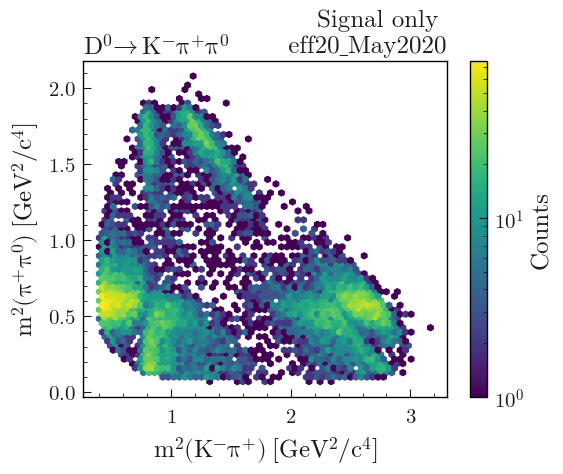

In [14]:
tag_dalitz = "eff20_May2020"
path_dalitz = f"{SIGNAL_BASE}/{cfg_kmpippi0['file_fmt'].format(tag=tag_dalitz)}:{cfg_kmpippi0['tree']}"

print(f"\n{'='*80}\n[Dalitz Plot] Loading {path_dalitz}")
df_dalitz = uproot.concatenate(path_dalitz, library="pd")

needed_cols = ['daughterInvM__bo0__cm__sp1__bc',  # m(K- pi+)
               'daughterInvM__bo1__cm__sp2__bc',  # m(pi+ pi0)
               cfg_kmpippi0['isig']]

missing = [c for c in needed_cols if c not in df_dalitz.columns]
if missing:
    print(f"[WARNING] Missing columns for Dalitz plot: {missing}")
else:
    df_sig_dalitz = df_dalitz.loc[df_dalitz[cfg_kmpippi0['isig']] == 1, needed_cols].dropna()
    
    m_kpi = df_sig_dalitz['daughterInvM__bo0__cm__sp1__bc'].to_numpy(dtype=float)
    m_pipi0 = df_sig_dalitz['daughterInvM__bo1__cm__sp2__bc'].to_numpy(dtype=float)
    
    x_dalitz = m_kpi**2
    y_dalitz = m_pipi0**2
    
    fig, ax = plt.subplots(figsize=(6, 5))
    hb = ax.hexbin(x_dalitz, y_dalitz, gridsize=60, bins="log", cmap="viridis")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Counts")
    
    ax.set_xlabel(r"$m^{2}(K^{-}\pi^{+})\;[\mathrm{GeV}^{2}/c^{4}]$")
    ax.set_ylabel(r"$m^{2}(\pi^{+}\pi^{0})\;[\mathrm{GeV}^{2}/c^{4}]$")
    ax.set_title(r"$D^{0}\!\to K^{-}\pi^{+}\pi^{0}$", loc="left")
    ax.set_title("Signal only "+"\n"+f" {tag_dalitz}", loc="right")
    
    plt.tight_layout()
    plt.show()

  ## Phase 2: Punzi FoM Calculation with 3σ D⁰ Mass Cut (CORRECTED)

  ### Helper Functions for Punzi FoM (OPTIMIZED)

In [8]:
def punzi_fom(epsS, B, a):
    """Punzi figure of merit: ε_S / (a/2 + sqrt(B))."""
    denom = (a / 2.0) + np.sqrt(max(B, 0.0))
    return 0.0 if denom <= 0.0 else epsS / denom

def load_ds_tree(tag, is_signal=True):
    """Load DstreeCh2 (Ds⁺ reconstruction) for given π⁰ tag - OPTIMIZED."""
    # ONLY load columns we actually need
    filter_cols = [VAR_D0_DM, VAR_LABEL]
    
    if is_signal:
        path = f"{SIGNAL_BASE}/output_test_kmpippi0_{tag}.root:{DS_TREE}"
        try:
            print(f"  Loading signal (columns: {filter_cols})... ", end="", flush=True)
            df = uproot.concatenate(path, filter_name=filter_cols, library="pd")
            print(f"{len(df):,} events")
            return df
        except Exception as e:
            print(f"\n[ERROR] Signal load failed for {tag}: {e}")
            return pd.DataFrame()
    else:
        # Load generic MC (all event types, merged)
        specs = []
        for ev_type in BKG_EVENT_TYPES:
            mono_path = f"{BKG_BASE}/Ds2D0e-Generic_M2_{tag}_Ds_101525_0_{ev_type}.root"
            if os.path.isfile(mono_path):
                specs.append(f"{mono_path}:{DS_TREE}")
            else:
                shard_dir = f"{BKG_BASE}/Ds2D0e-Generic_M2_{tag}_Ds_101525_0_{ev_type}_shards"
                if os.path.isdir(shard_dir):
                    import glob
                    parts = sorted(glob.glob(os.path.join(shard_dir, "part_*.root")))
                    specs.extend([f"{p}:{DS_TREE}" for p in parts])
        
        if not specs:
            print(f"[WARNING] No background files found for {tag}")
            return pd.DataFrame()
        
        try:
            print(f"  Loading background from {len(specs)} file(s) (columns: {filter_cols})... ", end="", flush=True)
            df = uproot.concatenate(specs, filter_name=filter_cols, library="pd")
            print(f"{len(df):,} events")
            return df
        except Exception as e:
            print(f"\n[ERROR] Background load failed for {tag}: {e}")
            return pd.DataFrame()

  ### Run Punzi FoM Scan (CORRECTED - Fixed Efficiency Denominator)

In [9]:
punzi_results = []
start_time = time.time()

for idx, tag in enumerate(EFF_TAGS, 1):
    print(f"\n{'='*80}")
    print(f"[Punzi FoM {idx}/{len(EFF_TAGS)}] Tag: {tag}")
    print(f"{'='*80}")
    
    # Get fitted D⁰ mass parameters (3σ window)
    fit_key = f"kmpippi0_{tag}"
    if fit_key not in fit_results:
        print(f"[SKIP] No fit results for {tag}")
        continue
    
    res_fit = fit_results[fit_key]
    mu = res_fit['mu'][0]
    sL = res_fit['sigmaL'][0]
    sR = res_fit['sigmaR'][0]
    d0_window = (mu - 3*sL, mu + 3*sR)
    
    print(f"3σ D⁰ mass window: [{d0_window[0]:.5f}, {d0_window[1]:.5f}] GeV/c²")
    
    # === Load FULL datasets (before cuts) - ONLY columns we need ===
    tag_start = time.time()
    
    sig_df_full = load_ds_tree(tag, is_signal=True)
    bkg_df_full = load_ds_tree(tag, is_signal=False)
    
    load_time = time.time() - tag_start
    print(f"  → Load time: {load_time:.1f}s")
    
    if sig_df_full.empty or bkg_df_full.empty:
        print(f"[SKIP] Empty signal or background for {tag}")
        continue
    
    print(f"\n[SANITY CHECK] Raw counts BEFORE 3σ cut:")
    print(f"  Signal MC reconstructed in Ds tree: {len(sig_df_full):,} events")
    print(f"  Background MC: {len(bkg_df_full):,} total events")
    
    # Check truth label exists
    if VAR_LABEL not in sig_df_full.columns:
        print(f"[SKIP] Missing truth label column: {VAR_LABEL}")
        continue
    
    # === SIGNAL EFFICIENCY (CORRECTED) ===
    # CRITICAL FIX: Use CONSTANT denominator (generated events)
    N_sig_total_generated = NGEN_SIGNAL  # 50,000 - CONSTANT for all tags!
    
    # Apply 3σ D⁰ mass cut
    sig_df_cut = sig_df_full[(sig_df_full[VAR_D0_DM] >= d0_window[0]) & 
                             (sig_df_full[VAR_D0_DM] <= d0_window[1])]
    
    # Count TRUE signal events passing cut
    sig_pure_pass = sig_df_cut[sig_df_cut[VAR_LABEL] == 1]
    N_sig_pass = len(sig_pure_pass)
    
    # TRUE total reconstruction efficiency (includes π⁰ reco losses + 3σ cut)
    ε_S = N_sig_pass / N_sig_total_generated  # Denominator NOW constant!
    
    # === BACKGROUND COUNT (no scaling) ===
    # All generic events after 3σ D⁰ cut (already at 200 fb⁻¹)
    bkg_df_cut = bkg_df_full[(bkg_df_full[VAR_D0_DM] >= d0_window[0]) & 
                             (bkg_df_full[VAR_D0_DM] <= d0_window[1])]
    B = len(bkg_df_cut)
    
    # Diagnostic breakdown
    N_sig_reconstructed = len(sig_df_full[sig_df_full[VAR_LABEL] == 1])
    ε_pi0_reco = N_sig_reconstructed / N_sig_total_generated
    ε_3sigma_acceptance = N_sig_pass / N_sig_reconstructed if N_sig_reconstructed > 0 else 0.0
    
    print(f"\n[EFFICIENCY BREAKDOWN]:")
    print(f"  Generated signal events: {N_sig_total_generated:,} (constant)")
    print(f"  Reconstructed in Ds tree: {N_sig_reconstructed:,}")
    print(f"  Passing 3σ D⁰ cut: {N_sig_pass:,}")
    print(f"  π⁰ reconstruction efficiency: {ε_pi0_reco:.4f} = {ε_pi0_reco*100:.2f}%")
    print(f"  3σ cut acceptance (of reconstructed): {ε_3sigma_acceptance:.4f} = {ε_3sigma_acceptance*100:.2f}%")
    print(f"  TOTAL efficiency ε_S: {ε_S:.6f} = {ε_S*100:.2f}%")
    print(f"\n[BACKGROUND]:")
    print(f"  Background events passing 3σ cut: {B:,}")
    
    # === PUNZI FoM ===
    for a_val in PUNZI_A_VALUES:
        P = punzi_fom(ε_S, B, a_val)
        punzi_results.append({
            'tag': tag,
            'a': a_val,
            'Punzi': P,
            'epsilonS': ε_S,
            'B': B,
            'N_sig_generated': N_sig_total_generated,
            'N_sig_reconstructed': N_sig_reconstructed,
            'N_sig_pass': N_sig_pass,
            'eps_pi0_reco': ε_pi0_reco,
            'eps_3sigma': ε_3sigma_acceptance,
            'd0_window': d0_window
        })
        print(f"  a={a_val:.2f}: Punzi={P:.6g}")
    
    # Clear memory
    del sig_df_full, bkg_df_full, sig_df_cut, bkg_df_cut
    gc.collect()

total_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"Total Punzi scan time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"{'='*80}")

# Convert to DataFrame for plotting
df_punzi = pd.DataFrame(punzi_results)


[Punzi FoM 1/5] Tag: eff10_May2020
3σ D⁰ mass window: [-0.04636, 0.02379] GeV/c²
  Loading signal (columns: ['D0_dM', 'Ds_ifNANgiveX_isSignal_5'])... 6,799 events
  Loading background from 6 file(s) (columns: ['D0_dM', 'Ds_ifNANgiveX_isSignal_5'])... 1,341,825 events
  → Load time: 44.7s

[SANITY CHECK] Raw counts BEFORE 3σ cut:
  Signal MC reconstructed in Ds tree: 6,799 events
  Background MC: 1,341,825 total events

[EFFICIENCY BREAKDOWN]:
  Generated signal events: 100,000 (constant)
  Reconstructed in Ds tree: 4,093
  Passing 3σ D⁰ cut: 3,882
  π⁰ reconstruction efficiency: 0.0409 = 4.09%
  3σ cut acceptance (of reconstructed): 0.9484 = 94.84%
  TOTAL efficiency ε_S: 0.038820 = 3.88%

[BACKGROUND]:
  Background events passing 3σ cut: 559,422
  a=1.64: Punzi=5.18454e-05
  a=1.96: Punzi=5.18343e-05
  a=3.00: Punzi=5.17983e-05

[Punzi FoM 2/5] Tag: eff20_May2020
3σ D⁰ mass window: [-0.05215, 0.02424] GeV/c²
  Loading signal (columns: ['D0_dM', 'Ds_ifNANgiveX_isSignal_5'])... 13,674 

  ### Plot Punzi FoM Comparison

/tmp/ipykernel_1844146/2830445837.py:26: UserWarning: Glyph 8304 (\N{SUPERSCRIPT ZERO}) missing from font(s) Latin Modern Math, Latin Modern Sans.
  plt.tight_layout()
/home/belle2/amubarak/env/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8304 (\N{SUPERSCRIPT ZERO}) missing from font(s) Latin Modern Math, Latin Modern Sans.
  fig.canvas.print_figure(bytes_io, **kw)


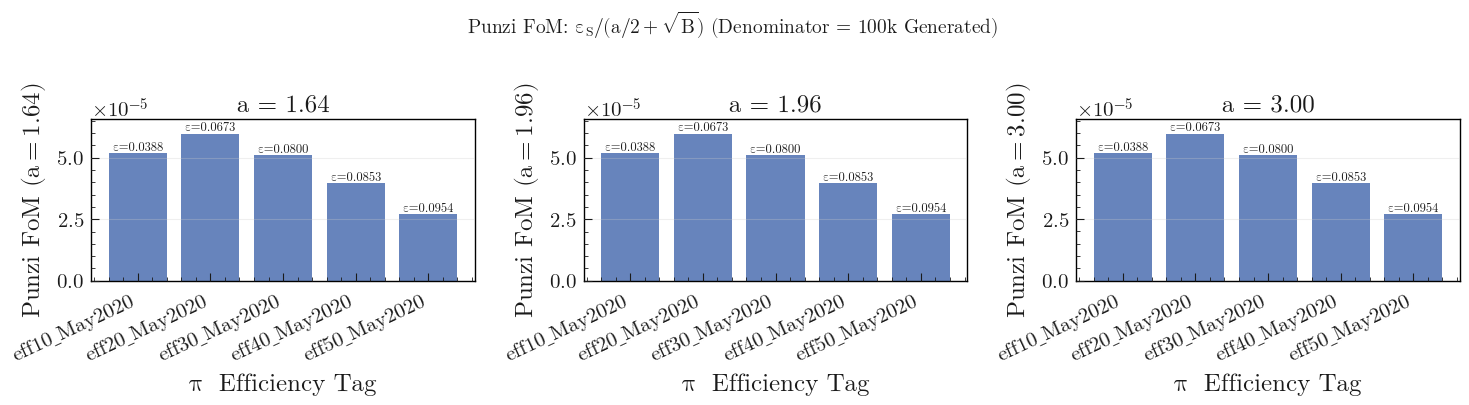


Punzi FoM Summary (CORRECTED: Denominator = 50,000 Generated Events)

a = 1.64:


,Punzi,ε_total,ε_π⁰_reco,ε_3σ_cut,B,N_pass
tag,,,,,,
eff10_May2020,0.000052,0.03882,0.04093,0.948449,559422,3882
eff20_May2020,0.000060,0.06727,0.07172,0.937953,1264474,6727
eff30_May2020,0.000051,0.07998,0.08547,0.935767,2459082,7998
eff40_May2020,0.000040,0.08532,0.09105,0.937068,4631593,8532
eff50_May2020,0.000027,0.09544,0.10331,0.923822,12389130,9544



a = 1.96:


,Punzi,ε_total,ε_π⁰_reco,ε_3σ_cut,B,N_pass
tag,,,,,,
eff10_May2020,0.000052,0.03882,0.04093,0.948449,559422,3882
eff20_May2020,0.000060,0.06727,0.07172,0.937953,1264474,6727
eff30_May2020,0.000051,0.07998,0.08547,0.935767,2459082,7998
eff40_May2020,0.000040,0.08532,0.09105,0.937068,4631593,8532
eff50_May2020,0.000027,0.09544,0.10331,0.923822,12389130,9544



a = 3.00:


,Punzi,ε_total,ε_π⁰_reco,ε_3σ_cut,B,N_pass
tag,,,,,,
eff10_May2020,0.000052,0.03882,0.04093,0.948449,559422,3882
eff20_May2020,0.000060,0.06727,0.07172,0.937953,1264474,6727
eff30_May2020,0.000051,0.07998,0.08547,0.935767,2459082,7998
eff40_May2020,0.000040,0.08532,0.09105,0.937068,4631593,8532
eff50_May2020,0.000027,0.09544,0.10331,0.923822,12389130,9544


In [10]:
if not df_punzi.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, a_val in enumerate(PUNZI_A_VALUES):
        df_a = df_punzi[df_punzi['a'] == a_val].sort_values('tag')
        
        ax = axes[i]
        bars = ax.bar(df_a['tag'], df_a['Punzi'], color='#4C6EB1', alpha=0.85)
        
        # Annotate bars with total efficiency
        for bar, row in zip(bars, df_a.itertuples()):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                    f"ε={row.epsilonS:.4f}",
                    ha='center', va='bottom', fontsize=9)
        
        ax.set_ylabel(rf"Punzi FoM ($a={a_val:.2f}$)")
        ax.set_xlabel("π⁰ Efficiency Tag")
        ax.set_title(f"a = {a_val:.2f}", loc='center')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.1*df_a['Punzi'].max() if len(df_a) > 0 else 1.0)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=25, ha='right')
    
    plt.suptitle(r"Punzi FoM: $\epsilon_S / (a/2 + \sqrt{B})$ (Denominator = 100k Generated)", 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*100)
    print("Punzi FoM Summary (CORRECTED: Denominator = 50,000 Generated Events)")
    print("="*100)
    for a_val in PUNZI_A_VALUES:
        print(f"\na = {a_val:.2f}:")
        df_a = df_punzi[df_punzi['a'] == a_val][['tag', 'Punzi', 'epsilonS', 'eps_pi0_reco', 'eps_3sigma', 'B', 'N_sig_pass']]
        df_a_display = df_a.copy()
        df_a_display.columns = ['tag', 'Punzi', 'ε_total', 'ε_π⁰_reco', 'ε_3σ_cut', 'B', 'N_pass']
        display(df_a_display.set_index('tag'))
else:
    print("[WARNING] No Punzi results to plot")

  ## 3σ Mass Window Summary for Steering Scripts

In [11]:
print("\n" + "="*100)
print("3σ D⁰ MASS WINDOWS FOR STEERING SCRIPTS")
print("="*100)
print("\nBased on fits to signal MC (50k events per sample)")
print("Apply these cuts to m(D⁰) - m_PDG(D⁰) variable\n")

# Collect all windows with simple column names
windows_data = []

# kmpip and km3pi (symmetric Gaussian)
for mode in RUN_MODES:
    if mode in fit_results:
        res = fit_results[mode]
        mu = res['mu'][0]
        sigma = res['sigma'][0]
        lower = mu - 3*sigma
        upper = mu + 3*sigma
        windows_data.append({
            'Mode': mode,
            'Tag': 'N/A',
            'μ': mu,
            'σ_L': sigma,
            'σ_R': sigma,
            'Lower': lower,
            'Upper': upper,
        })

# kmpippi0 (bifurcated Gaussian for each tag)
for tag in EFF_TAGS:
    fit_key = f"kmpippi0_{tag}"
    if fit_key in fit_results:
        res = fit_results[fit_key]
        mu = res['mu'][0]
        sL = res['sigmaL'][0]
        sR = res['sigmaR'][0]
        lower = mu - 3*sL
        upper = mu + 3*sR
        windows_data.append({
            'Mode': 'kmpippi0',
            'Tag': tag,
            'μ': mu,
            'σ_L': sL,
            'σ_R': sR,
            'Lower': lower,
            'Upper': upper,
        })

df_windows = pd.DataFrame(windows_data)

# Display formatted table
df_windows_display = df_windows.copy()
df_windows_display['μ (GeV/c²)'] = df_windows_display['μ'].apply(lambda x: f"{x:.6f}")
df_windows_display['σ_L (GeV/c²)'] = df_windows_display['σ_L'].apply(lambda x: f"{x:.6f}")
df_windows_display['σ_R (GeV/c²)'] = df_windows_display['σ_R'].apply(lambda x: f"{x:.6f}")
df_windows_display['Lower (GeV/c²)'] = df_windows_display['Lower'].apply(lambda x: f"{x:.6f}")
df_windows_display['Upper (GeV/c²)'] = df_windows_display['Upper'].apply(lambda x: f"{x:.6f}")

display(df_windows_display[['Mode', 'Tag', 'μ (GeV/c²)', 'σ_L (GeV/c²)', 'σ_R (GeV/c²)', 'Lower (GeV/c²)', 'Upper (GeV/c²)']])

print("\n" + "="*100)
print("STEERING SCRIPT CUTS (Python format - copy-paste ready)")
print("="*100)
print()

# Print in steering script format
for _, row in df_windows.iterrows():
    mode = row['Mode']
    tag = row['Tag']
    lower = row['Lower']
    upper = row['Upper']
    
    if tag == 'N/A':
        var_name = f"Ds_D0{mode}_Cut"
        print(f'{var_name} = "massDifference(0) <= 0.5 and {lower:.6f} <= daughter(0,dM) <= {upper:.6f}"')
    else:
        var_name = f"Ds_D0kmpippi0_{tag}_Cut"
        print(f'{var_name} = "massDifference(0) <= 0.5 and {lower:.6f} <= daughter(0,dM) <= {upper:.6f}"')

print("\n" + "="*100)


3σ D⁰ MASS WINDOWS FOR STEERING SCRIPTS

Based on fits to signal MC (50k events per sample)
Apply these cuts to m(D⁰) - m_PDG(D⁰) variable



,Mode,Tag,μ (GeV/c²),σ_L (GeV/c²),σ_R (GeV/c²),Lower (GeV/c²),Upper (GeV/c²)
0,kmpip,N/A,-0.000069,0.004740,0.004740,-0.014291,0.014152
1,km3pi,N/A,-0.000286,0.004269,0.004269,-0.013093,0.012520
2,kmpippi0,eff10_May2020,-0.000840,0.015173,0.008210,-0.046359,0.023790
3,kmpippi0,eff20_May2020,-0.000578,0.017191,0.008271,-0.052152,0.024237
4,kmpippi0,eff30_May2020,-0.000665,0.017541,0.008353,-0.053289,0.024394
5,kmpippi0,eff40_May2020,-0.000604,0.017607,0.008403,-0.053424,0.024603
6,kmpippi0,eff50_May2020,0.000113,0.020833,0.007880,-0.062387,0.023752



STEERING SCRIPT CUTS (Python format - copy-paste ready)

Ds_D0kmpip_Cut = "massDifference(0) <= 0.5 and -0.014291 <= daughter(0,dM) <= 0.014152"
Ds_D0km3pi_Cut = "massDifference(0) <= 0.5 and -0.013093 <= daughter(0,dM) <= 0.012520"
Ds_D0kmpippi0_eff10_May2020_Cut = "massDifference(0) <= 0.5 and -0.046359 <= daughter(0,dM) <= 0.023790"
Ds_D0kmpippi0_eff20_May2020_Cut = "massDifference(0) <= 0.5 and -0.052152 <= daughter(0,dM) <= 0.024237"
Ds_D0kmpippi0_eff30_May2020_Cut = "massDifference(0) <= 0.5 and -0.053289 <= daughter(0,dM) <= 0.024394"
Ds_D0kmpippi0_eff40_May2020_Cut = "massDifference(0) <= 0.5 and -0.053424 <= daughter(0,dM) <= 0.024603"
Ds_D0kmpippi0_eff50_May2020_Cut = "massDifference(0) <= 0.5 and -0.062387 <= daughter(0,dM) <= 0.023752"



  ### Background Composition Analysis (D⁰ Level, After 3σ Cut)

  ## Summary

  **Phase 1 Complete**: Fitted D⁰ mass for all modes and extracted σ values
  **Phase 2 Complete**: Applied 3σ D⁰ cuts and computed Punzi FoM across π⁰ efficiency tags

  **CRITICAL FIX APPLIED:**
  - Signal efficiency now computed with CONSTANT denominator: ε_S = N_sig_pass / 50,000
  - This gives TRUE total reconstruction efficiency (π⁰ reco × 3σ cut acceptance)
  - Background count uses raw events: B = len(bkg_df_cut) (no scaling, already at 200 fb⁻¹)
  - Sanity checks print efficiency breakdown: π⁰ reco efficiency, 3σ acceptance, total efficiency
  - Legend positioning fixed: Data at top-left, fit parameters at top-right
  - Mass windows formatted as Python steering script cuts
  - **NEW:** 3σ boundaries shown with vertical dashed lines + gray shading on excluded regions

  **Next Steps**:
  - Validate 3σ windows on sideband data
  - Optimize BDT for background suppression in Ds⁺ domain
  - Systematic uncertainties (shape modeling, efficiency variations)